# First part : Almost same data processing as in the other Notebook, you can directly jump to the second part for the text classification 

In [ ]:
import pandas as pd
import numpy as np
import itertools
import random
from collections import Counter
import tqdm

import spacy
nlp = spacy.load('en_core_web_sm')

import matplotlib.pyplot as plt

In [ ]:
data_train = pd.read_csv('D:\\5data\\archive\\test.ft.txt\\test.ft.txt', delimiter = "\t", header = None)
data_train = data_train.sample(n=25000, random_state=1)

In [ ]:
data_train['output'] = data_train[0].apply(lambda x : x[:10])

data_train['data'] = data_train[0].apply(lambda x : x[10:])

data_train = data_train.drop([0], axis = 1)

In [ ]:
data_train = data_train.reset_index()

In [ ]:
clean_text = []
pbar = tqdm.tqdm(total=len(data_train['data']),position=0, leave=True)

for text in nlp.pipe(data_train['data'], disable=["tagger", "parser", "ner"]):

    txt = [token.lemma_.lower() for token in text 
         if token.is_alpha 
         and not token.is_stop 
         and not token.is_punct]

    clean_text.append(txt)


    pbar.update(1)

100%|████████████████████████████████████████████████████████████████████████████| 25000/25000 [04:23<00:00, 94.94it/s]
C:\Users\Victo\anaconda3\lib\site-packages\spacy\pipeline\lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)
100%|██████████████████████████████████████████████████████████████████████████▉| 24994/25000 [02:35<00:00, 243.11it/s]

In [ ]:
data_train['clean_text'] = clean_text

In [ ]:
from gensim.models import Word2Vec

In [ ]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [ ]:
# train word2vec model
w2v_model = Word2Vec(sentences=data_train['clean_text'], vector_size=300, window=5, min_count=2, workers=2, epochs=5)

2022-03-13 22:11:56,025 : INFO : collecting all words and their counts
2022-03-13 22:11:56,026 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2022-03-13 22:11:56,108 : INFO : PROGRESS: at sentence #10000, processed 340439 words, keeping 32540 word types
2022-03-13 22:11:56,179 : INFO : PROGRESS: at sentence #20000, processed 677972 words, keeping 46818 word types
2022-03-13 22:11:56,214 : INFO : collected 52780 word types from a corpus of 847925 raw words and 25000 sentences
2022-03-13 22:11:56,215 : INFO : Creating a fresh vocabulary
2022-03-13 22:11:56,360 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=2 retains 27531 unique words (52.16180371352785%% of original 52780, drops 25249)', 'datetime': '2022-03-13T22:11:56.360559', 'gensim': '4.1.2', 'python': '3.8.12 (default, Oct 12 2021, 03:01:40) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.22000-SP0', 'event': 'prepare_vocab'}
2022-03-13 22:11:56,361 : INFO : Word2Vec lifecycle

In [ ]:
# check out cosine similarity for some word-vectors
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
keyboard = w2v_model.wv['keyboard'].reshape(1,300)
webcam = w2v_model.wv['webcam'].reshape(1,300)
mouse = w2v_model.wv['mouse'].reshape(1,300)
pc = w2v_model.wv['pc'].reshape(1,300)

In [ ]:

def get_mean_vector(word2vec_model, words):
    # remove out-of-vocabulary words
    words = [word for word in words if word in w2v_model.wv.key_to_index]
    if len(words) >= 1:
        return np.mean(word2vec_model.wv[words], axis=0)
    else:
        return []

In [ ]:
avg_rev_vecs = data_train['clean_text'].map(lambda t: get_mean_vector(w2v_model, t))

In [ ]:
avg_rev_vecs = data_train['clean_text'].map(lambda t: get_mean_vector(w2v_model, t))

100%|███████████████████████████████████████████████████████████████████████████| 25000/25000 [02:47<00:00, 243.11it/s]

In [ ]:
avg_rev_vecs = np.vstack(avg_rev_vecs)

# Second part : Text classification

In [ ]:
import mglearn
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

#### We'll use as features the average vector of the reviews. It means that we'll have 300 features for 25000 thousands observations

In [ ]:
data_vecs = pd.DataFrame(avg_rev_vecs)
#data_vecs['y'] = data_train['output']

In [ ]:
def dummy_fun(doc):
    return doc
tfidf = TfidfVectorizer(vocabulary=w2v_model.wv.key_to_index.keys(),
    tokenizer=dummy_fun,
    preprocessor=dummy_fun,
    token_pattern=None)  
# Tfidf matrix  
df_tfidf = tfidf.fit_transform(data_train['clean_text'])

In [ ]:

df_w2v_tfidf = df_tfidf @ w2v_model.wv.vectors
sims = cosine_similarity(df_w2v_tfidf[10].reshape(1,300), df_w2v_tfidf)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    data_vecs, data_train['output'], test_size = 4000, stratify=data_train['output'], random_state=0)


#### First we ran a simple logistic regression and check the accuracy of the training and the test set. 

In [ ]:
logreg = LogisticRegression().fit(X_train, y_train)
#logreg = LogisticRegression(max_iter=5000).fit(X_train, y_train)

print("Accuracy (training): {:.3f}".format(logreg.score(X_train, y_train)))
print("Accuracy (test): {:.3f}".format(logreg.score(X_test, y_test)))


Accuracy (training): 0.796
Accuracy (test): 0.797


C:\Users\Victo\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


#### By adding regularization we can significantly increase the accuracy of the model

In [ ]:
accuracy_log = []
for c in [0.001,0.01,0.1,1,2,5,10,50,100]:
    logregc = LogisticRegression(max_iter=5000,C=c).fit(X_train,y_train)
    print("Accuracy C= ", c, " (test): {:.3f}".format(logregc.score(X_test, y_test)))
    accuracy_log.append(logregc.score(X_test, y_test))

Accuracy C=  0.001  (test): 0.753
Accuracy C=  0.01  (test): 0.777
Accuracy C=  0.1  (test): 0.789
Accuracy C=  1  (test): 0.797
Accuracy C=  2  (test): 0.802
Accuracy C=  5  (test): 0.805
Accuracy C=  10  (test): 0.807
Accuracy C=  50  (test): 0.816
Accuracy C=  100  (test): 0.821


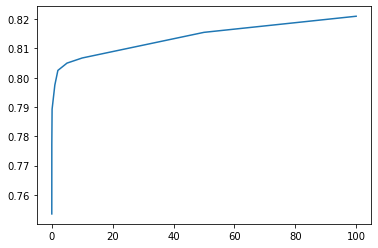

In [ ]:
plt.plot([0.001,0.01,0.1,1,2,5,10,50,100], accuracy_log, 'bx-')
plt.xlabel('C')
plt.ylabel('Accuracy ')
plt.title('Log model : variation of accuracy regarding value of C')
plt.show()

In [ ]:
from sklearn.svm import SVC

In [ ]:
svc = SVC()

# Fit the model on the training set 
svc.fit(X_train, y_train)

print("Accuracy (training): {:.3f}".format(svc.score(X_train, y_train)))
print("Accuracy (test): {:.3f}".format(svc.score(X_test, y_test)))


Accuracy (training): 0.799
Accuracy (test): 0.798


#### Same model but with scaled data

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
svc_accuracy = []
for c in [0.1,1,2]:

    svc = SVC(kernel='linear', C=c, verbose=1)
    svc.fit(X_train_scaled, y_train)
    print('C = ', c)
    print("Accuracy (training): {:.3f}".format(svc.score(X_train_scaled, y_train)))
    print("Accuracy (test): {:.3f}".format(svc.score(X_test_scaled, y_test)))
    svc_accuracy.append(svc.score(X_test_scaled, y_test))
    

[LibSVM]C =  0.1
Accuracy (training): 0.811
Accuracy (test): 0.807
[LibSVM]C =  1
Accuracy (training): 0.827
Accuracy (test): 0.827
[LibSVM]C =  2
Accuracy (training): 0.830
Accuracy (test): 0.830


#### We can also try the same models using the tfidf transformation

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    df_w2v_tfidf, data_train['output'], test_size = 4000, stratify=data_train['output'], random_state=0)


In [ ]:
logreg001 = LogisticRegression(max_iter=5000, C=0.001).fit(X_train, y_train)
logreg50 = LogisticRegression(max_iter=5000, C=50).fit(X_train, y_train)

print("Accuracy C=0.001 (test): {:.3f}".format(logreg001.score(X_test, y_test)))
print("Accuracy C=50 (test): {:.3f}".format(logreg50.score(X_test, y_test)))


Accuracy C=0.001 (test): 0.777
Accuracy C=50 (test): 0.835


In [ ]:
accuracy_log = []
for c in [0.001,0.01,0.1,1,2,5,10,50,100]:
    logregc = LogisticRegression(max_iter=5000,C=c).fit(X_train,y_train)
    print("Accuracy C= ", c, " (test): {:.3f}".format(logregc.score(X_test, y_test)))
    accuracy_log.append(logregc.score(X_test, y_test))

Accuracy C=  0.001  (test): 0.777
Accuracy C=  0.01  (test): 0.793
Accuracy C=  0.1  (test): 0.805
Accuracy C=  1  (test): 0.810
Accuracy C=  2  (test): 0.816
Accuracy C=  5  (test): 0.820
Accuracy C=  10  (test): 0.824
Accuracy C=  50  (test): 0.835
Accuracy C=  100  (test): 0.834


C:\Users\Victo\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


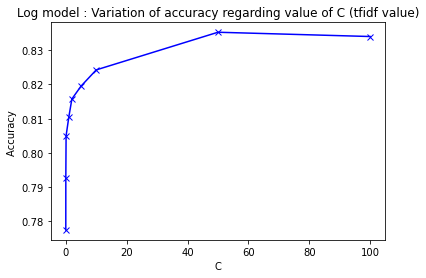

In [ ]:
plt.plot([0.001,0.01,0.1,1,2,5,10,50,100], accuracy_log, 'bx-')
plt.xlabel('C')
plt.ylabel('Accuracy ')
plt.title('Log model : Variation of accuracy regarding value of C (tfidf value)')
plt.show()

In [ ]:
svc_accuracy = []
for c in [0.1,1,2]:

    svc = SVC(kernel='linear', C=c, verbose=1)
    svc.fit(X_train, y_train)
    print('C = ', c)
    print("Accuracy (training): {:.3f}".format(svc.score(X_train, y_train)))
    print("Accuracy (test): {:.3f}".format(svc.score(X_test, y_test)))
    svc_accuracy.append(svc.score(X_test, y_test))
    

[LibSVM]

In [ ]:
plt.plot([0.1,1,2],svc_accuracy, 'bx-')
plt.xlabel('C')
plt.ylabel('Accuracy ')
plt.title('SVM model : Variation of accuracy regarding value of C (tfidf value)' )
plt.show()